# Feature Extraction and Selection
Data cleanup, extract useful features to use as training data, filter and lower dimensionality

In [0]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression

In [0]:
clinics = pd.read_csv('clinics.csv')
patients = pd.read_csv('patients.csv')
matchings = pd.read_csv('matchings.csv')

In [0]:
# split data for training/testing
train_test_sp = 220
x_train = patients.iloc[:train_test_sp]
y_train = matchings.iloc[:train_test_sp]
x_test = patients.iloc[train_test_sp:]
y_test = matchings.iloc[train_test_sp:]

y_train=y_train.drop('Unnamed: 0', axis=1)
y_test=y_test.drop('Unnamed: 0', axis=1)
x_train = x_train.fillna(0)
x_test = x_test.fillna(0)

x_train.to_csv("x_train.csv")
y_train.to_csv("y_train.csv")
x_test.to_csv("x_test.csv")
y_test.to_csv("y_test.csv")
assert len(x_train) == len(y_train)
assert len(x_test) == len(y_test)

In [144]:
y_train

,MatchedClinic
0,2
1,16
2,11
3,9
4,20
...,...
215,26
216,20
217,27
218,19


## Utils

In [0]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since):
    now = time.time()
    s = now - since
    return 'Time elapsed: %s (%s to %s)' % (asMinutes(s), asMinutes(since), asMinutes(now))

## Mutual info Regression
Drop useless columns

In [0]:
def filter_features(X_train, y_train, X_test= None):
    ''' 
    performs mutual info regression on training data to filter out
    less useful features

    @returns
        filtered_trainingset: dataframe of filtered training data set
        filtered_test: dataframe of filtered test data set
    '''
    X_train = X_train.fillna(0)
    y_train = y_train.fillna(0)
    mir = mutual_info_regression(X_train, y_train)
    mirfeature_scores = sorted([(mir[i], i) for i in range(X_train.shape[1])])
    filtered_features = [feature[1] for feature in mirfeature_scores if feature[0] > 0]
    filtered_trainingset = X_train.iloc[:, filtered_features]
    filtered_test = X_test.iloc[:, filtered_features] if X_test is not None else None
    return filtered_trainingset, filtered_test

In [0]:
train_f, test_f = filter_features(x_train, y_train, x_test)
train_f.to_csv("filtered_x_train.csv")
test_f.to_csv("filtered_x_test.csv")

In [0]:
# reduced from 45 to 37 columns
train_f.shape

(220, 37)

# Principle Component Analysis

In [0]:
def run_PCA(x_train, n_components=6, x_test= None, saveto="pca_x_train.csv"):
    '''
    Performs PCA on x_train

    @returns 
        x_train_pca: pca training data DataFrame
        pca: pca model
        saveto: output filename for x_train_pca
    '''
    pca = PCA(n_components=n_components, whiten=False)

    start = time.time()

    pca.fit(x_train)
    x_pca = pca.transform(x_train)
    x_train_pca = pd.DataFrame(x_pca)

    if saveto != "":
        x_train_pca.to_csv(saveto)

    x_test_pca = pd.DataFrame(pca.transform(x_test)) if x_test is not None else None

    end = time.time()
    elapsed = end - start
    print('Fit time elapsed: {}'.format(elapsed))

    if x_test_pca is not None:
        x_test_pca.to_csv("pca_x_test.csv")

    return x_train_pca, pca, x_test_pca

In [151]:
x_pca, pca_model, x_test_pca = run_PCA(x_train, x_test=x_test)

Fit time elapsed: 0.015213251113891602


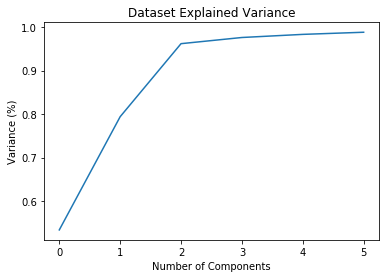

In [147]:
plt.figure()
plt.plot(np.cumsum(pca_model.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

In [0]:
x_pca

,0,1,2,3,4,5
0,-57.068586,857.234258,-326.007646,-138.306951,99.816021,-82.180260
1,-1522.080588,209.256661,578.767747,145.586300,-105.167404,-9.352576
2,371.733915,-793.784478,112.972014,-20.085526,223.955528,-184.432096
3,-1551.881211,722.306822,928.522797,304.022549,53.151712,6.589133
4,-1220.002029,-232.291970,-211.120074,-1.157704,-118.292128,-47.520371
...,...,...,...,...,...,...
215,-310.589628,-627.729187,735.141177,-213.972863,-31.565189,18.722406
216,-1251.291174,-361.754250,172.165564,-88.868182,-200.583636,-16.967206
217,-1460.645273,277.297641,79.815921,205.658990,-28.907858,22.354075
218,564.044837,-689.451821,-217.973013,98.113121,136.227602,42.306382
